# PCA and Modelling

Here are the steps to be undertaken:
1. Perform Tokenization
2. Scale numeric features
3. Perform PCA
4. Run several models and optimize hyperparameters
5. Choose optimal model for KMeans

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import functions_library as fl

In [3]:
#the beauty review dataset with the cleaning and feature engineering steps applied
df = fl.pipedf('All_Beauty.json.gz')

### Tokenization

- For reviewText, will use: lemmatizer, ngrams 1-2, **min_df = 1000**
- For summary, will use: lemmatizer, ngrams 1-2, **min_df = 800**

In [4]:
#getting review tokens which will be prepended with 'r_'
review_tokens = fl.tfidf(df['reviewText'], tokenizer=fl.spl_tokenizer, ngram_range=(1,2), min_df=1000)

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [5]:
#getting summary tokens which will be prepended with 's_'
summary_tokens = fl.tfidf(df['summary'], tokenizer=fl.spl_tokenizer, ngram_range=(1,2), min_df=800)

### Scale numeric features
Will be using the MinMaxScaler to scale the non-token features.

In [6]:
#getting the numeric features (no tokens)
df2=df.select_dtypes(include=['int32','int64'])

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
#instantiate minmaxscaler
mm = MinMaxScaler()

In [9]:
#fit transform data using minmaxscaler
df3 = mm.fit_transform(df2)

In [10]:
#put the scaled into a dataframe
df_scaled = pd.DataFrame(df3, columns = df2.columns)

In [11]:
df_scaled.shape

(362252, 12)

In [12]:
#saving memory
del df3, df2

#### Now let's bring in the tokens to get the final dataframe.

In [13]:
#concatenating the scaled non-token features and the review & summary tokens
df_final = pd.concat([df_scaled, review_tokens, summary_tokens], axis = 1)

In [14]:
#save data
df_final.to_csv('all_tokens_scaled.zip', compression='zip')

In [15]:
df_final.tail()

,overall,verified,vote,review_word_count,summary_word_count,month,dayofweek,multipleReviews_reviewer,reviewer_five_star_only,reviewer_one_star_only,...,s_well,s_without,s_wonderful,s_work,s_work s_great,s_work s_well,s_worked,s_worth,s_would,s_year
362247,0.00,1.0,0.000000,0.011057,0.087248,0.545455,0.500000,0.0,0.0,1.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362248,1.00,1.0,0.012495,0.017199,0.006711,0.181818,0.500000,0.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362249,1.00,1.0,0.016906,0.001638,0.013423,0.181818,0.333333,0.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362250,0.25,1.0,0.000000,0.011057,0.060403,0.090909,0.166667,0.0,0.0,0.0,...,0.457313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362251,0.25,1.0,0.000000,0.012695,0.053691,1.000000,0.500000,1.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
del review_tokens, summary_tokens, df_scaled, df

### Perform PCA
As we have seen above, the final dataframe contains 1347 features so we will do dimensionality reduction using PCA.

In [17]:
#import PCA
from sklearn.decomposition import PCA

In [18]:
# Create a PCA instance: pca
pca = PCA(n_components=500)
pcs = pca.fit_transform(df_final)

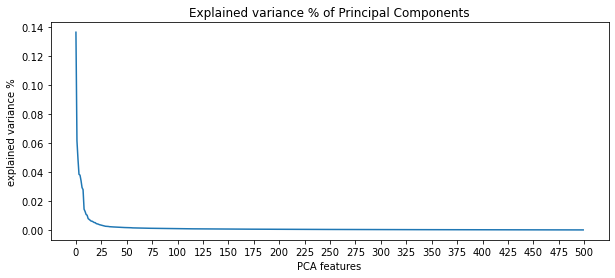

In [19]:
# Plot the explained variances
plt.figure(figsize=(10,4))
plt.plot(range(500), pca.explained_variance_ratio_[0:500])
plt.xlabel('PCA features')
plt.ylabel('explained variance %')
plt.xticks(range(0,501,25))
plt.title('Explained variance % of Principal Components')
plt.show()

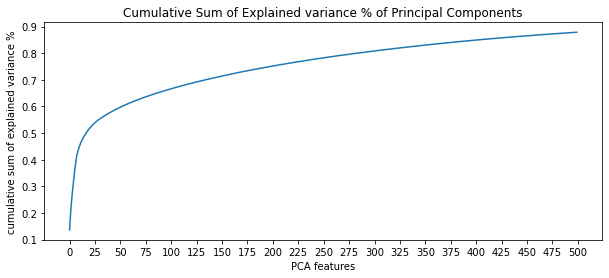

In [20]:
# Plot the cumulative sum of explained variances
plt.figure(figsize=(10,4))
plt.plot(range(500), pca.explained_variance_ratio_.cumsum()[0:500])
plt.xlabel('PCA features')
plt.ylabel('cumulative sum of explained variance %')
plt.xticks(range(0,501,25))
plt.title('Cumulative Sum of Explained variance % of Principal Components')
plt.show()

From the above, we want to have as much explained variance as possible from the least number of principal components. As a rough guide, we want to be able to have at least 80% explained variance.

In [21]:
#explained variance for 300 PCs
pca.explained_variance_ratio_.cumsum()[300]

0.8084281843678117

In [22]:
#explained variance for 350 PCs
pca.explained_variance_ratio_.cumsum()[350]

0.830425713328625

In [23]:
#explained variance for 400 PCs
pca.explained_variance_ratio_.cumsum()[400]

0.8493514181603637

300 PCs provides 80% explained variance. 400 PCs gets close to 85%. For later modelling, let's try using **350 PCs** as we get a decent tradeoff: 50 more features for 2.2% increase in explained variance compared to 300 PCs.

In [24]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(pcs)

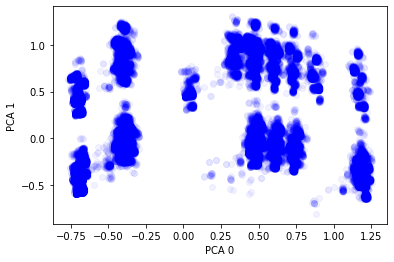

In [25]:
#this is what the first two features look like (plot)
plt.figure()
plt.scatter(PCA_components[0],PCA_components[1], alpha=.05, color='blue')
plt.xlabel('PCA 0')
plt.ylabel('PCA 1')
plt.show()

## KMeans Clustering
We can now begin building our model. For this project we would using Kmeans clustering

In [26]:
from sklearn.cluster import KMeans

In [27]:
#we begin by trying to determine the optimal number of clusters by looking at inertia scores
#cycle through different K values and append inertia score to list
k_values = range(8,32)
inertia_scores = []

for k in k_values:
    #instantiate
    kmeans_model = KMeans(n_clusters=k, n_jobs=5, verbose=1)
    #fitting on first 350 PCs
    kmeans_model.fit(PCA_components.iloc[:,0:350])
    #get scores and append them
    inertia = kmeans_model.inertia_
    #append score
    inertia_scores.append(inertia)

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 1055724.0707756833
Iteration 1, inertia 619981.3867482251
Iteration 2, inertia 600334.8287785441
Iteration 3, inertia 594398.3070207359
Iteration 4, inertia 590935.275070039
Iteration 5, inertia 589980.6675122858
Iteration 6, inertia 589134.2528204503
Iteration 7, inertia 588256.2470112263
Iteration 8, inertia 587201.7927178665
Iteration 9, inertia 585730.9301426898
Iteration 10, inertia 582799.8353839676
Iteration 11, inertia 575735.6331930101
Iteration 12, inertia 574799.9805273986
Iteration 13, inertia 574781.2432720144
Iteration 14, inertia 574772.1915573508
Iteration 15, inertia 574771.8385274542
Converged at iteration 15: center shift 4.994283331843454e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 885726.4526941831
Iteration 1, inertia 595386.7423139215
Iteration 2, inertia 583330.492319008
Iteration 3, inertia 581110.2845655831
Iteration 4, inertia 580609.4984569292
Iteration 5, inertia 58038

Iteration 7, inertia 583411.9270267672
Iteration 8, inertia 583410.7227958837
Iteration 9, inertia 583410.431322214
Iteration 10, inertia 583410.2545729062
Iteration 11, inertia 583410.2250006407
Converged at iteration 11: center shift 6.236966577656744e-08 within tolerance 6.771770691904755e-07.


C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 936812.4375498705
Iteration 1, inertia 601998.0154547036
Iteration 2, inertia 585395.7051774757
Iteration 3, inertia 584459.7341046551
Iteration 4, inertia 584052.8222566748
Iteration 5, inertia 583892.9385490974
Iteration 6, inertia 583818.5094550577
Iteration 7, inertia 583778.3371468973
Iteration 8, inertia 583719.4820925455
Iteration 9, inertia 583626.2202924474
Iteration 10, inertia 583395.5744098499
Iteration 11, inertia 582936.9756449416
Iteration 12, inertia 582407.8845638795
Iteration 13, inertia 581828.8590169199
Iteration 14, inertia 580815.1086426835
Iteration 15, inertia 575642.8078068789
Iteration 16, inertia 571552.1926751831
Iteration 17, inertia 571431.7832840751
Iteration 18, inertia 571431.01770744
Converged at iteration 18: center shift 2.800223054413342e-08 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 1024625.6173689009
Iteration 1, inertia 608182.4238597868
Iteration 2, inertia 59

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 810016.6341231046
Iteration 1, inertia 607803.0270260185
Iteration 2, inertia 586947.5437992895
Iteration 3, inertia 577393.3936497237
Iteration 4, inertia 571708.5539488737
Iteration 5, inertia 571232.1363094359
Iteration 6, inertia 571095.0530903115
Iteration 7, inertia 571083.7969829809
Iteration 8, inertia 571078.8649586843
Iteration 9, inertia 571077.5626499538
Iteration 10, inertia 571077.0794158351
Iteration 11, inertia 571076.9922646404
Iteration 12, inertia 571076.9766730734
Converged at iteration 12: center shift 5.393214883392041e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 930689.8335064464
Iteration 1, inertia 586471.3446436794
Iteration 2, inertia 563151.9825170945
Iteration 3, inertia 553269.72835068
Iteration 4, inertia 552869.860053618
Iteration 5, inertia 552707.6624102641
Iteration 6, inertia 552502.8034460361
Iteration 7, inertia 552252.8847323625
Iteration 8, inertia 551988.358

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 928289.5625270813
Iteration 1, inertia 583056.4607505332
Iteration 2, inertia 574103.2007989805
Iteration 3, inertia 571512.9396116446
Iteration 4, inertia 568539.6695743679
Iteration 5, inertia 565716.2706653465
Iteration 6, inertia 558953.879894806
Iteration 7, inertia 558203.9807924868
Iteration 8, inertia 557821.4417797644
Iteration 9, inertia 557060.1964170579
Iteration 10, inertia 555309.755304475
Iteration 11, inertia 550893.4361169476
Iteration 12, inertia 550227.1231225566
Iteration 13, inertia 550227.09900266
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, inertia 961682.8562106466
Iteration 1, inertia 573871.7845872722
Iteration 2, inertia 564797.9625662257
Iteration 3, inertia 562449.0380731385
Iteration 4, inertia 559494.4059701636
Iteration 5, inertia 557886.4525892615
Iteration 6, inertia 557636.0722700444
Iteration 7, inertia 557488.4366881828
Iteration 8, inertia 557359.681007157
Iteration

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 900527.372730119
Iteration 1, inertia 569671.3429401038
Iteration 2, inertia 563687.9736185411
Iteration 3, inertia 562873.297918908
Iteration 4, inertia 562720.35918722
Iteration 5, inertia 562632.7674237068
Iteration 6, inertia 562571.3148266369
Iteration 7, inertia 562517.5588740665
Iteration 8, inertia 562492.3644664113
Iteration 9, inertia 562445.251736333
Iteration 10, inertia 562396.391335145
Iteration 11, inertia 562346.9528080265
Iteration 12, inertia 562309.2230706344
Iteration 13, inertia 562283.3253413484
Iteration 14, inertia 562273.0024801642
Iteration 15, inertia 562260.9681542128
Iteration 16, inertia 562247.2272596358
Iteration 17, inertia 562225.2057582223
Iteration 18, inertia 562217.6357583724
Iteration 19, inertia 562217.5333409304
Iteration 20, inertia 562217.4119599559
Iteration 21, inertia 562217.2480408744
Iteration 22, inertia 562217.0143826256
Iteration 23, inertia 562216.5151612125
Iteration 24, inertia 562214.566

Iteration 9, inertia 556405.9446760673
Iteration 10, inertia 556211.5495382127
Iteration 11, inertia 555834.5074918976
Iteration 12, inertia 555019.2631312258
Iteration 13, inertia 553023.957916837
Iteration 14, inertia 548368.5834505779
Iteration 15, inertia 547898.737910448
Iteration 16, inertia 547898.1350776217
Iteration 17, inertia 547898.090371531
Iteration 18, inertia 547898.0806679763
Converged at iteration 18: center shift 4.0867361546866114e-08 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 857621.7609665559
Iteration 1, inertia 575374.7260409441
Iteration 2, inertia 557346.4359825017
Iteration 3, inertia 554385.5256473774
Iteration 4, inertia 551762.3251052763
Iteration 5, inertia 550865.5888629479
Iteration 6, inertia 550827.7606369976
Iteration 7, inertia 550796.3887878846
Iteration 8, inertia 550778.8939749823
Iteration 9, inertia 550770.5603769574
Iteration 10, inertia 550761.7627298188
Iteration 11, inertia 550758.905371397
Iteratio

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 894420.851315246
Iteration 1, inertia 567068.7265032778
Iteration 2, inertia 560663.2016178124
Iteration 3, inertia 553414.7020424834
Iteration 4, inertia 549384.8516055761
Iteration 5, inertia 548994.7653558431
Iteration 6, inertia 548806.0000663722
Iteration 7, inertia 548670.1573919902
Iteration 8, inertia 548583.7478158872
Iteration 9, inertia 548542.1064676656
Iteration 10, inertia 548519.7743117491
Iteration 11, inertia 548500.2610213491
Iteration 12, inertia 548488.4492636088
Iteration 13, inertia 548487.4451856321
Iteration 14, inertia 548487.0296094881
Converged at iteration 14: center shift 5.5345332376964056e-08 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 851932.658574899
Iteration 1, inertia 563616.6160669896
Iteration 2, inertia 548971.0047408331
Iteration 3, inertia 547270.7289457793
Iteration 4, inertia 546775.7468649141
Iteration 5, inertia 546609.478388068
Iteration 6, inertia 546523.

Initialization complete
Iteration 0, inertia 938023.7644219786
Iteration 1, inertia 572880.1207099458
Iteration 2, inertia 551516.6456756049
Iteration 3, inertia 549511.8642486286
Iteration 4, inertia 549246.0118072092
Iteration 5, inertia 549015.8592462088
Iteration 6, inertia 548838.9766943748
Iteration 7, inertia 548709.7096104204
Iteration 8, inertia 548631.2996596546
Iteration 9, inertia 548599.2500767627
Iteration 10, inertia 548578.649527975
Iteration 11, inertia 548565.8931046576
Iteration 12, inertia 548564.8680900522
Iteration 13, inertia 548564.6099396133
Iteration 14, inertia 548564.5161775725
Iteration 15, inertia 548564.3157959601
Iteration 16, inertia 548564.2690513934
Converged at iteration 16: center shift 9.536309536072054e-08 within tolerance 6.771770691904755e-07.


C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 866400.5621956399
Iteration 1, inertia 566529.8032465252
Iteration 2, inertia 542962.4563136164
Iteration 3, inertia 540199.6647036483
Iteration 4, inertia 539404.8955896567
Iteration 5, inertia 538179.1031780996
Iteration 6, inertia 536063.5649419796
Iteration 7, inertia 535815.765240421
Iteration 8, inertia 535801.9447685275
Iteration 9, inertia 535798.2019077957
Iteration 10, inertia 535796.6838342134
Iteration 11, inertia 535794.349058621
Iteration 12, inertia 535794.1523255066
Iteration 13, inertia 535793.9520413124
Iteration 14, inertia 535793.6934310818
Iteration 15, inertia 535793.6467475832
Converged at iteration 15: center shift 1.2339165557190094e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 923060.6243997323
Iteration 1, inertia 566702.1012865969
Iteration 2, inertia 554578.0537988454
Iteration 3, inertia 552198.3809820354
Iteration 4, inertia 550991.0596100815
Iteration 5, inertia 54785

Iteration 16, inertia 534654.7842206924
Iteration 17, inertia 534507.4346028094
Iteration 18, inertia 534172.6344751406
Iteration 19, inertia 533207.3916477825
Iteration 20, inertia 531400.0746910763
Iteration 21, inertia 526979.4861513427
Iteration 22, inertia 526186.265027177
Iteration 23, inertia 525950.2101960704
Iteration 24, inertia 525929.273677466
Converged at iteration 24: center shift 5.691149189544123e-07 within tolerance 6.771770691904755e-07.


C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 869899.9864731028
Iteration 1, inertia 540610.4666355548
Iteration 2, inertia 526330.6433502793
Iteration 3, inertia 523812.2553375319
Iteration 4, inertia 521571.73825042887
Iteration 5, inertia 520586.52693038684
Iteration 6, inertia 520526.20757336315
Iteration 7, inertia 520473.8467967048
Iteration 8, inertia 520429.5782040312
Iteration 9, inertia 520381.3180748358
Iteration 10, inertia 520343.4759758529
Iteration 11, inertia 520297.5748117454
Iteration 12, inertia 520211.0163673942
Iteration 13, inertia 520159.6933733879
Iteration 14, inertia 520115.2513247959
Iteration 15, inertia 520077.216600574
Iteration 16, inertia 520039.7388419016
Iteration 17, inertia 520002.88492295635
Iteration 18, inertia 519969.9240751292
Iteration 19, inertia 519927.1022293803
Iteration 20, inertia 519879.1792567778
Iteration 21, inertia 519846.144644579
Iteration 22, inertia 519837.68899183697
Iteration 23, inertia 519827.14621636027
Iteration 24, inertia 

Iteration 21, inertia 529492.9899867055
Iteration 22, inertia 529492.6697380102
Iteration 23, inertia 529492.4551847482
Iteration 24, inertia 529492.3640378898
Iteration 25, inertia 529492.3269092523
Iteration 26, inertia 529492.2931030156
Converged at iteration 26: center shift 5.901466000442129e-07 within tolerance 6.771770691904755e-07.


C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 782325.2824094703
Iteration 1, inertia 549972.0762095634
Iteration 2, inertia 538101.8625716387
Iteration 3, inertia 535535.1426630679
Iteration 4, inertia 533318.2396568567
Iteration 5, inertia 532853.9235912291
Iteration 6, inertia 532532.9652032515
Iteration 7, inertia 532437.9417378798
Iteration 8, inertia 532395.5327946264
Iteration 9, inertia 532385.3686553796
Iteration 10, inertia 532382.3247599554
Iteration 11, inertia 532381.3725380424
Iteration 12, inertia 532381.0902812538
Iteration 13, inertia 532380.9918824831
Iteration 14, inertia 532380.9724932301
Converged at iteration 14: center shift 3.056477850300782e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 814842.5356780671
Iteration 1, inertia 572591.4051479031
Iteration 2, inertia 557579.2858288727
Iteration 3, inertia 537176.5492991706
Iteration 4, inertia 531041.7044589125
Iteration 5, inertia 530196.5639261857
Iteration 6, inertia 52960

Iteration 17, inertia 527602.6743069859
Iteration 18, inertia 527476.0877814888
Iteration 19, inertia 526784.5642888508
Iteration 20, inertia 525440.5114396366
Iteration 21, inertia 521477.4609908661
Iteration 22, inertia 519869.6682834549
Iteration 23, inertia 519858.9604173348
Iteration 24, inertia 519853.128296139
Iteration 25, inertia 519851.17679614923
Iteration 26, inertia 519851.05095138494
Iteration 27, inertia 519850.8862534955
Iteration 28, inertia 519850.64760594285
Iteration 29, inertia 519849.98086230736
Iteration 30, inertia 519847.2562274249
Iteration 31, inertia 519840.3525600457
Iteration 32, inertia 519838.88469199813
Iteration 33, inertia 519838.8311434667
Converged at iteration 33: center shift 2.8034455056350616e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 794072.5069425452
Iteration 1, inertia 560903.201625368
Iteration 2, inertia 555066.1128480148
Iteration 3, inertia 554730.2713169386
Iteration 4, inertia 553952.062697

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 821063.6258806551
Iteration 1, inertia 553333.8934997093
Iteration 2, inertia 536593.1908706144
Iteration 3, inertia 532447.907538746
Iteration 4, inertia 531186.7451825301
Iteration 5, inertia 529502.3959776176
Iteration 6, inertia 527920.1740497804
Iteration 7, inertia 527618.0907508963
Iteration 8, inertia 527464.8030324099
Iteration 9, inertia 527305.3774181731
Iteration 10, inertia 526807.7433468038
Iteration 11, inertia 525695.9922717852
Iteration 12, inertia 525604.5912717326
Iteration 13, inertia 525602.522568114
Iteration 14, inertia 525602.4168836052
Converged at iteration 14: center shift 6.481468564560278e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 801878.4493868145
Iteration 1, inertia 539364.4124003574
Iteration 2, inertia 522287.36852144555
Iteration 3, inertia 519003.774696133
Iteration 4, inertia 517337.0940772531
Iteration 5, inertia 514940.3082525498
Iteration 6, inertia 514279.

Iteration 7, inertia 524135.77763214026
Iteration 8, inertia 524135.530576843
Iteration 9, inertia 524135.09370508057
Iteration 10, inertia 524134.92688796157
Iteration 11, inertia 524134.50719096296
Iteration 12, inertia 524133.54306895053
Iteration 13, inertia 524131.56480653567
Iteration 14, inertia 524126.86008765723
Iteration 15, inertia 524112.7245093626
Iteration 16, inertia 524072.4475415715
Iteration 17, inertia 524059.96467272943
Iteration 18, inertia 524059.2417352115
Iteration 19, inertia 524059.2314148475
Converged at iteration 19: strict convergence.
Initialization complete
Iteration 0, inertia 773483.5052644796
Iteration 1, inertia 548417.814615526
Iteration 2, inertia 539626.8060051631
Iteration 3, inertia 538028.3812077466
Iteration 4, inertia 537274.8699224514
Iteration 5, inertia 536297.5878356851
Iteration 6, inertia 534098.2146440742
Iteration 7, inertia 529348.6737935945
Iteration 8, inertia 529016.6864247959
Iteration 9, inertia 529014.6915338933
Iteration 10, in

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 824054.1346200432
Iteration 1, inertia 547700.9512105826
Iteration 2, inertia 523857.5830869504
Iteration 3, inertia 519197.4188260904
Iteration 4, inertia 517555.1478912419
Iteration 5, inertia 515703.33075827203
Iteration 6, inertia 513747.2852870952
Iteration 7, inertia 513644.3571502821
Iteration 8, inertia 513622.68118831265
Iteration 9, inertia 513606.49320524046
Iteration 10, inertia 513598.10927006864
Iteration 11, inertia 513597.00507202075
Iteration 12, inertia 513596.633765348
Iteration 13, inertia 513596.3893432695
Iteration 14, inertia 513596.1026881117
Iteration 15, inertia 513595.6140807671
Iteration 16, inertia 513594.62759369594
Iteration 17, inertia 513592.4340346899
Iteration 18, inertia 513591.9659874846
Iteration 19, inertia 513591.82271514833
Iteration 20, inertia 513591.7085777852
Iteration 21, inertia 513591.5766304284
Iteration 22, inertia 513591.37045835494
Iteration 23, inertia 513591.08929744846
Iteration 24, iner

Initialization complete
Iteration 0, inertia 778678.0458017593
Iteration 1, inertia 558734.0584924116
Iteration 2, inertia 537724.0377721944
Iteration 3, inertia 526503.175587275
Iteration 4, inertia 517055.333225032
Iteration 5, inertia 516235.1533238385
Iteration 6, inertia 515810.26878307114
Iteration 7, inertia 515506.2023970825
Iteration 8, inertia 515354.84872101113
Iteration 9, inertia 515327.8279367922
Iteration 10, inertia 515316.7188392175
Iteration 11, inertia 515312.6004657521
Iteration 12, inertia 515311.96694575856
Iteration 13, inertia 515310.7514390726
Iteration 14, inertia 515310.1481396743
Iteration 15, inertia 515309.9316976851
Converged at iteration 15: center shift 6.178939210390126e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 809195.8982912002
Iteration 1, inertia 554544.8934937228
Iteration 2, inertia 542610.5096568377
Iteration 3, inertia 531946.1361181595
Iteration 4, inertia 528578.0505278052
Iteration 5, inertia 528

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 800124.716449711
Iteration 1, inertia 531086.2872232039
Iteration 2, inertia 520510.775425509
Iteration 3, inertia 518022.4813139872
Iteration 4, inertia 515051.7522196007
Iteration 5, inertia 514259.1364284065
Iteration 6, inertia 513825.8294018276
Iteration 7, inertia 513060.1226679158
Iteration 8, inertia 511401.320980656
Iteration 9, inertia 510959.800617849
Iteration 10, inertia 510943.92913724715
Iteration 11, inertia 510943.55353023834
Iteration 12, inertia 510943.41365536285
Iteration 13, inertia 510943.321996518
Iteration 14, inertia 510943.1869283507
Converged at iteration 14: center shift 6.641963681559071e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 914666.371302375
Iteration 1, inertia 540664.2170754944
Iteration 2, inertia 525785.2194545794
Iteration 3, inertia 519145.2203249326
Iteration 4, inertia 513300.7373977729
Iteration 5, inertia 512503.13453804713
Iteration 6, inertia 512350.

Iteration 5, inertia 520175.9744215497
Iteration 6, inertia 519940.1708072864
Iteration 7, inertia 519620.778019842
Iteration 8, inertia 519459.3433502466
Iteration 9, inertia 519395.71151577006
Iteration 10, inertia 519395.49342715536
Iteration 11, inertia 519395.3349423035
Iteration 12, inertia 519395.3078780243
Iteration 13, inertia 519395.27555803617
Iteration 14, inertia 519395.235946046
Iteration 15, inertia 519395.1662383248
Iteration 16, inertia 519395.14261194656
Converged at iteration 16: center shift 3.7647179840483325e-08 within tolerance 6.771770691904755e-07.


C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 796575.5857926245
Iteration 1, inertia 533054.9264637908
Iteration 2, inertia 521479.8752238378
Iteration 3, inertia 517028.82841599226
Iteration 4, inertia 513810.6119549479
Iteration 5, inertia 512789.7586018757
Iteration 6, inertia 512592.971162793
Iteration 7, inertia 512480.5087984223
Iteration 8, inertia 512420.72436395055
Iteration 9, inertia 512408.86307555245
Iteration 10, inertia 512401.3805303487
Iteration 11, inertia 512396.8253048694
Iteration 12, inertia 512391.10228456155
Iteration 13, inertia 512390.42198683333
Iteration 14, inertia 512390.3811825959
Iteration 15, inertia 512390.3595007518
Converged at iteration 15: center shift 6.060935346968744e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 801657.0620362001
Iteration 1, inertia 539057.3850053595
Iteration 2, inertia 524231.40207224863
Iteration 3, inertia 522726.9223006409
Iteration 4, inertia 520328.10167283996
Iteration 5, inerti

Iteration 11, inertia 515222.7548187559
Iteration 12, inertia 515221.0016226576
Iteration 13, inertia 515220.261605358
Iteration 14, inertia 515219.20475057885
Iteration 15, inertia 515216.83306927216
Iteration 16, inertia 515214.8684283879
Iteration 17, inertia 515203.9995095533
Iteration 18, inertia 515161.4947346356
Iteration 19, inertia 515136.79605719645
Iteration 20, inertia 515136.50208372594
Iteration 21, inertia 515136.48628936365
Converged at iteration 21: center shift 2.0481933302357128e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 786264.83466004
Iteration 1, inertia 546707.3624017821
Iteration 2, inertia 538003.7166153727
Iteration 3, inertia 536618.9689969178
Iteration 4, inertia 535494.3711237287
Iteration 5, inertia 532693.172738474
Iteration 6, inertia 528964.9016930303
Iteration 7, inertia 522222.267263402
Iteration 8, inertia 519763.6575552191
Iteration 9, inertia 519736.41470044566
Iteration 10, inertia 519722.25364368
Iter

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 759880.4558769556
Iteration 1, inertia 531470.8105737383
Iteration 2, inertia 520512.44917091035
Iteration 3, inertia 518707.51141045085
Iteration 4, inertia 517423.69429712556
Iteration 5, inertia 516442.06242199347
Iteration 6, inertia 516121.02851280407
Iteration 7, inertia 515730.97662893723
Iteration 8, inertia 515453.76764474565
Iteration 9, inertia 515389.4921111734
Iteration 10, inertia 515367.0720300936
Iteration 11, inertia 515358.1927515797
Iteration 12, inertia 515354.75012619275
Iteration 13, inertia 515352.765718425
Iteration 14, inertia 515351.88924943
Iteration 15, inertia 515351.71445276233
Iteration 16, inertia 515351.65523176454
Iteration 17, inertia 515351.6252285682
Converged at iteration 17: center shift 6.718790169994342e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 726756.3903923933
Iteration 1, inertia 519615.90928787756
Iteration 2, inertia 510363.0127231818
Iteration 3, in

Iteration 6, inertia 502250.97488529107
Iteration 7, inertia 502164.9503893427
Iteration 8, inertia 502146.4885491006
Iteration 9, inertia 502141.0582217506
Iteration 10, inertia 502135.297345029
Iteration 11, inertia 502126.68965843384
Iteration 12, inertia 502117.5943143652
Iteration 13, inertia 502109.9945099085
Iteration 14, inertia 502100.115039551
Iteration 15, inertia 502088.75396632793
Iteration 16, inertia 502083.27580497117
Iteration 17, inertia 502081.72744775005
Iteration 18, inertia 502081.65659993433
Converged at iteration 18: center shift 5.638961383902129e-07 within tolerance 6.771770691904755e-07.


C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 788050.8689106698
Iteration 1, inertia 517906.54573026433
Iteration 2, inertia 503182.860350129
Iteration 3, inertia 501721.84880789695
Iteration 4, inertia 500892.43114756077
Iteration 5, inertia 497998.95137137885
Iteration 6, inertia 497546.87317275186
Iteration 7, inertia 497514.31485657115
Iteration 8, inertia 497505.0281077192
Iteration 9, inertia 497498.3326119706
Iteration 10, inertia 497490.6288987702
Iteration 11, inertia 497487.6353339544
Iteration 12, inertia 497487.33031577506
Iteration 13, inertia 497487.17759468325
Iteration 14, inertia 497487.10509971716
Iteration 15, inertia 497487.0805650813
Iteration 16, inertia 497487.06743181165
Converged at iteration 16: center shift 2.961891882781623e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 740245.9788044019
Iteration 1, inertia 520633.6282728064
Iteration 2, inertia 509251.9687686208
Iteration 3, inertia 507409.65498993814
Iteration 4, i

Iteration 13, inertia 501884.43858464214
Iteration 14, inertia 501884.40981296747
Iteration 15, inertia 501884.3822520125
Iteration 16, inertia 501884.3702584521
Iteration 17, inertia 501884.36051859724
Iteration 18, inertia 501884.3540647602
Converged at iteration 18: center shift 4.2854697633111937e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 861536.1026594484
Iteration 1, inertia 518644.47519266116
Iteration 2, inertia 499403.48954584094
Iteration 3, inertia 494601.59389854566
Iteration 4, inertia 493995.4133976679
Iteration 5, inertia 493765.86139032827
Iteration 6, inertia 493494.52763725567
Iteration 7, inertia 493248.1752049317
Iteration 8, inertia 493097.1656967
Iteration 9, inertia 492975.72885353875
Iteration 10, inertia 492938.39801266894
Iteration 11, inertia 492901.17537667253
Iteration 12, inertia 492884.53181899304
Iteration 13, inertia 492866.928343398
Iteration 14, inertia 492866.30592882354
Iteration 15, inertia 492864.75363

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 757670.6686979232
Iteration 1, inertia 513934.43180281564
Iteration 2, inertia 501246.4823724813
Iteration 3, inertia 498813.89429921476
Iteration 4, inertia 496007.7984521675
Iteration 5, inertia 494500.50630843587
Iteration 6, inertia 493193.1541927816
Iteration 7, inertia 491321.3025427029
Iteration 8, inertia 490813.3522074574
Iteration 9, inertia 490719.0059144599
Iteration 10, inertia 490715.73754955066
Iteration 11, inertia 490714.31772127154
Iteration 12, inertia 490713.7044292645
Iteration 13, inertia 490713.38181296765
Iteration 14, inertia 490713.2261409317
Iteration 15, inertia 490713.15375080693
Iteration 16, inertia 490713.1006284966
Iteration 17, inertia 490713.0768210593
Iteration 18, inertia 490713.04898700287
Iteration 19, inertia 490712.94427639426
Iteration 20, inertia 490712.84899956733
Iteration 21, inertia 490712.82409952354
Converged at iteration 21: center shift 2.1545451045889107e-07 within tolerance 6.7717706919047

Iteration 12, inertia 497800.2523076431
Iteration 13, inertia 497729.8751147711
Iteration 14, inertia 497728.6862729452
Iteration 15, inertia 497728.67328887095
Converged at iteration 15: center shift 9.712034105087752e-08 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 771646.6896189577
Iteration 1, inertia 514732.8759458219
Iteration 2, inertia 502701.3667744922
Iteration 3, inertia 500768.172600085
Iteration 4, inertia 500580.7837371994
Iteration 5, inertia 500535.7501271131
Iteration 6, inertia 500461.7419053142
Iteration 7, inertia 500320.314423942
Iteration 8, inertia 500182.2232638809
Iteration 9, inertia 499956.9210777637
Iteration 10, inertia 499907.4830172852
Iteration 11, inertia 499893.24265418336
Iteration 12, inertia 499859.1766469159
Iteration 13, inertia 499773.07984947116
Iteration 14, inertia 499683.3535924883
Iteration 15, inertia 499622.04910220735
Iteration 16, inertia 499589.1077694982
Iteration 17, inertia 499581.39170263795
I

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 711865.8474681613
Iteration 1, inertia 511363.41415772284
Iteration 2, inertia 496635.87530167913
Iteration 3, inertia 491109.6047887467
Iteration 4, inertia 489319.95428355364
Iteration 5, inertia 489019.5766750118
Iteration 6, inertia 488935.61273804854
Iteration 7, inertia 488914.1187341357
Iteration 8, inertia 488860.87863280554
Iteration 9, inertia 488848.3733222531
Iteration 10, inertia 488834.43262862146
Iteration 11, inertia 488816.8304085063
Iteration 12, inertia 488809.17191432614
Converged at iteration 12: center shift 7.165355574098955e-08 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 742901.4819465037
Iteration 1, inertia 531618.5057643321
Iteration 2, inertia 517895.53385939734
Iteration 3, inertia 513384.12017101306
Iteration 4, inertia 510595.88787107903
Iteration 5, inertia 508556.3064162575
Iteration 6, inertia 507988.8154794039
Iteration 7, inertia 507737.672620719
Iteration 8, inerti

Iteration 14, inertia 496624.12121301465
Iteration 15, inertia 496607.5330026872
Iteration 16, inertia 496564.7658787274
Iteration 17, inertia 496530.58126238233
Iteration 18, inertia 496485.2576203522
Iteration 19, inertia 496394.83014390914
Iteration 20, inertia 496152.5699009861
Iteration 21, inertia 494496.14912986406
Iteration 22, inertia 492213.9660703153
Iteration 23, inertia 491949.0733758641
Iteration 24, inertia 491900.3275210721
Iteration 25, inertia 491883.1185540759
Iteration 26, inertia 491871.3412604499
Iteration 27, inertia 491869.4200836569
Iteration 28, inertia 491869.0000226778
Iteration 29, inertia 491868.4378246263
Iteration 30, inertia 491868.375797153
Iteration 31, inertia 491868.32518056553
Iteration 32, inertia 491868.30740982626
Converged at iteration 32: center shift 3.756438434740534e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 783667.2668034602
Iteration 1, inertia 523281.4233786437
Iteration 2, inertia 506029.735

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 722976.5409942813
Iteration 1, inertia 528137.4965275567
Iteration 2, inertia 514481.124660627
Iteration 3, inertia 510610.28712240705
Iteration 4, inertia 506366.7166825341
Iteration 5, inertia 504510.78326870856
Iteration 6, inertia 501376.33520223346
Iteration 7, inertia 497981.95940682926
Iteration 8, inertia 497715.95256703906
Iteration 9, inertia 497683.2456199636
Iteration 10, inertia 497657.4546078139
Iteration 11, inertia 497639.86939417786
Iteration 12, inertia 497620.4005647146
Iteration 13, inertia 497612.4059475093
Iteration 14, inertia 497606.9893671679
Iteration 15, inertia 497603.5037782817
Iteration 16, inertia 497601.61945641926
Iteration 17, inertia 497598.8549328471
Iteration 18, inertia 497453.34086988453
Iteration 19, inertia 496478.22540085827
Iteration 20, inertia 496319.1242009731
Iteration 21, inertia 496318.31173184287
Iteration 22, inertia 496316.67644073354
Iteration 23, inertia 496310.93083986064
Iteration 24, i

Iteration 22, inertia 477080.9912071144
Iteration 23, inertia 477080.97735909704
Converged at iteration 23: center shift 1.8051361181119124e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 738149.7950019492
Iteration 1, inertia 518930.3599461942
Iteration 2, inertia 499149.91574944265
Iteration 3, inertia 497565.7842791236
Iteration 4, inertia 497042.7935933585
Iteration 5, inertia 496836.770632808
Iteration 6, inertia 496784.4447337901
Iteration 7, inertia 496766.4707072146
Iteration 8, inertia 496748.8525750229
Iteration 9, inertia 496735.1727356425
Iteration 10, inertia 496714.2288402982
Iteration 11, inertia 496704.60875225073
Iteration 12, inertia 496692.6809404958
Iteration 13, inertia 496683.2553980916
Iteration 14, inertia 496672.466538252
Iteration 15, inertia 496664.1711820188
Iteration 16, inertia 496660.3529502884
Iteration 17, inertia 496654.1656810026
Iteration 18, inertia 496644.3447289263
Converged at iteration 18: center shift 5.

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 758729.1065658734
Iteration 1, inertia 515605.44682533597
Iteration 2, inertia 499972.4762953549
Iteration 3, inertia 493447.96248631546
Iteration 4, inertia 489907.8269463723
Iteration 5, inertia 485156.70673725737
Iteration 6, inertia 484667.5147138914
Iteration 7, inertia 484568.61965423555
Iteration 8, inertia 484536.02455583547
Iteration 9, inertia 484509.9120149406
Iteration 10, inertia 484503.2864448734
Iteration 11, inertia 484501.77874779777
Iteration 12, inertia 484499.29224951094
Iteration 13, inertia 484491.2071726744
Iteration 14, inertia 484475.85407051723
Iteration 15, inertia 484442.4328377192
Iteration 16, inertia 484441.06584309565
Iteration 17, inertia 484432.98881028383
Iteration 18, inertia 484422.85151481634
Iteration 19, inertia 484416.9475585291
Iteration 20, inertia 484416.6854589859
Iteration 21, inertia 484416.60407423007
Iteration 22, inertia 484416.38333030377
Iteration 23, inertia 484414.9212997764
Iteration 24,

Iteration 56, inertia 493844.9121939805
Iteration 57, inertia 493844.6148801766
Iteration 58, inertia 493844.52720646147
Iteration 59, inertia 493844.4881788384
Iteration 60, inertia 493844.46469340334
Iteration 61, inertia 493844.4514871274
Converged at iteration 61: center shift 1.693684731406673e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 748726.9269714045
Iteration 1, inertia 500935.1348743779
Iteration 2, inertia 491148.96476055734
Iteration 3, inertia 488091.1865908502
Iteration 4, inertia 487490.6436543218
Iteration 5, inertia 487164.6518788827
Iteration 6, inertia 487049.0181071003
Iteration 7, inertia 486994.83752690145
Iteration 8, inertia 486980.22995851503
Iteration 9, inertia 486977.0075636082
Iteration 10, inertia 486975.96771100536
Iteration 11, inertia 486975.409019011
Iteration 12, inertia 486975.19917414425
Iteration 13, inertia 486975.06884070684
Iteration 14, inertia 486974.91215519665
Iteration 15, inertia 486974.6621378

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 790537.4728882369
Iteration 1, inertia 512365.69649930653
Iteration 2, inertia 495349.7103801084
Iteration 3, inertia 488673.8827111015
Iteration 4, inertia 486553.4146415638
Iteration 5, inertia 485647.8531539937
Iteration 6, inertia 484673.2207683458
Iteration 7, inertia 482985.5879685454
Iteration 8, inertia 482085.898563286
Iteration 9, inertia 481562.5649592902
Iteration 10, inertia 481507.8039949974
Iteration 11, inertia 481465.20426328405
Iteration 12, inertia 481441.45668676496
Iteration 13, inertia 481428.61110603344
Iteration 14, inertia 481412.44262683735
Iteration 15, inertia 481406.00225022365
Iteration 16, inertia 481404.2058923256
Iteration 17, inertia 481403.94330807833
Iteration 18, inertia 481403.9155590423
Converged at iteration 18: center shift 4.3330119358779887e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 744759.3735987863
Iteration 1, inertia 520306.91473766504
Iteration 2, i

Iteration 13, inertia 488656.92129340925
Iteration 14, inertia 488654.16740036366
Iteration 15, inertia 488653.6225827821
Iteration 16, inertia 488653.40359174594
Iteration 17, inertia 488652.99623944506
Iteration 18, inertia 488650.91462847
Iteration 19, inertia 488647.0746157965
Iteration 20, inertia 488643.7760124845
Iteration 21, inertia 488636.2724548727
Iteration 22, inertia 488624.81230895396
Iteration 23, inertia 488618.74274829275
Iteration 24, inertia 488612.3362559447
Iteration 25, inertia 488603.27642436884
Iteration 26, inertia 488601.8386039447
Iteration 27, inertia 488601.3613963896
Iteration 28, inertia 488600.749810567
Iteration 29, inertia 488600.26822375896
Iteration 30, inertia 488599.87142002693
Iteration 31, inertia 488599.32011365006
Iteration 32, inertia 488597.9689766811
Iteration 33, inertia 488596.5112156089
Iteration 34, inertia 488595.0371970899
Iteration 35, inertia 488592.9447403351
Iteration 36, inertia 488589.40380493324
Iteration 37, inertia 488578.719

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 689753.0223672879
Iteration 1, inertia 505598.11583771324
Iteration 2, inertia 495614.7411047624
Iteration 3, inertia 494795.9966033523
Iteration 4, inertia 494556.16451596475
Iteration 5, inertia 494463.27018462337
Iteration 6, inertia 494434.6349425604
Iteration 7, inertia 494424.39531862154
Iteration 8, inertia 494421.02657008154
Iteration 9, inertia 494418.0169877019
Iteration 10, inertia 494409.8569430045
Iteration 11, inertia 494396.6636575934
Iteration 12, inertia 494392.798750717
Iteration 13, inertia 494390.7895224238
Iteration 14, inertia 494390.726676063
Iteration 15, inertia 494390.72226082254
Converged at iteration 15: center shift 4.799557688357371e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 716559.1329961914
Iteration 1, inertia 507785.8452765285
Iteration 2, inertia 491420.3822134703
Iteration 3, inertia 487940.00614957925
Iteration 4, inertia 487160.90937708993
Iteration 5, inerti

Iteration 23, inertia 477230.7954122153
Iteration 24, inertia 477230.79369083175
Converged at iteration 24: strict convergence.
Initialization complete
Iteration 0, inertia 720813.7806801627
Iteration 1, inertia 500425.02676364384
Iteration 2, inertia 486851.72840887925
Iteration 3, inertia 484380.1212463023
Iteration 4, inertia 482000.04123813845
Iteration 5, inertia 480438.663341917
Iteration 6, inertia 480287.52094961435
Iteration 7, inertia 480174.8407151465
Iteration 8, inertia 480103.1169204148
Iteration 9, inertia 480051.07515336585
Iteration 10, inertia 480038.14177511696
Iteration 11, inertia 480031.05521755177
Iteration 12, inertia 480028.9242555588
Iteration 13, inertia 480026.07789850526
Iteration 14, inertia 480022.4247122947
Iteration 15, inertia 480020.20631954155
Iteration 16, inertia 480018.20172452496
Iteration 17, inertia 480015.9050794787
Iteration 18, inertia 480013.6530973365
Iteration 19, inertia 480012.4908057952
Iteration 20, inertia 480010.37449283816
Iteratio

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 740241.3372116148
Iteration 1, inertia 495095.4145228604
Iteration 2, inertia 477802.57827553136
Iteration 3, inertia 475615.7316403351
Iteration 4, inertia 475056.75932431675
Iteration 5, inertia 474769.16940001893
Iteration 6, inertia 474564.2153190751
Iteration 7, inertia 474379.09122982225
Iteration 8, inertia 474165.4004424236
Iteration 9, inertia 473930.27503164054
Iteration 10, inertia 473768.27680192125
Iteration 11, inertia 473749.8399106298
Iteration 12, inertia 473747.78377840517
Iteration 13, inertia 473746.3362342628
Iteration 14, inertia 473743.3101660877
Iteration 15, inertia 473737.99090178544
Iteration 16, inertia 473737.4830941912
Iteration 17, inertia 473736.89216820494
Iteration 18, inertia 473736.1475354621
Iteration 19, inertia 473735.03696654085
Iteration 20, inertia 473732.3745565343
Iteration 21, inertia 473721.1351994482
Iteration 22, inertia 473705.96151001577
Iteration 23, inertia 473693.6976332943
Iteration 24, i

Iteration 11, inertia 478750.47571321385
Iteration 12, inertia 478694.0279594639
Iteration 13, inertia 478677.2186307106
Iteration 14, inertia 478663.795686391
Iteration 15, inertia 478661.6073304914
Iteration 16, inertia 478661.13146541367
Iteration 17, inertia 478661.06503777124
Iteration 18, inertia 478661.05878485844
Converged at iteration 18: center shift 1.7267654324686697e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 716539.226124474
Iteration 1, inertia 507208.7196542968
Iteration 2, inertia 489126.71074293164
Iteration 3, inertia 485067.71966084937
Iteration 4, inertia 484423.2758477207
Iteration 5, inertia 484118.4887266311
Iteration 6, inertia 483971.2768867142
Iteration 7, inertia 483749.2624860487
Iteration 8, inertia 483505.81026546285
Iteration 9, inertia 483316.33740894
Iteration 10, inertia 483214.9539814844
Iteration 11, inertia 483172.08303997316
Iteration 12, inertia 483142.84176202957
Iteration 13, inertia 483123.723613621

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 698429.5296257238
Iteration 1, inertia 493890.95258373825
Iteration 2, inertia 483028.19832651236
Iteration 3, inertia 481442.2436283179
Iteration 4, inertia 480814.0669402875
Iteration 5, inertia 479266.1634295575
Iteration 6, inertia 477809.2606274883
Iteration 7, inertia 477763.19820854836
Iteration 8, inertia 477720.96237541805
Iteration 9, inertia 477712.5794957471
Iteration 10, inertia 477712.2328313469
Iteration 11, inertia 477712.0757456555
Iteration 12, inertia 477712.0169632562
Iteration 13, inertia 477711.9912156807
Iteration 14, inertia 477711.96552684513
Iteration 15, inertia 477711.9527557095
Iteration 16, inertia 477711.93928435387
Iteration 17, inertia 477711.9309316645
Iteration 18, inertia 477711.9266976067
Iteration 19, inertia 477711.924698176
Converged at iteration 19: strict convergence.
Initialization complete
Iteration 0, inertia 674244.4405098662
Iteration 1, inertia 502658.2309810208
Iteration 2, inertia 487642.1957

Iteration 18, inertia 480417.39137570636
Converged at iteration 18: center shift 4.623557673061652e-07 within tolerance 6.771770691904755e-07.
Initialization complete
Iteration 0, inertia 697698.6622189397
Iteration 1, inertia 498093.12187677686
Iteration 2, inertia 486746.15830949787
Iteration 3, inertia 481043.75198051165
Iteration 4, inertia 478266.97528610553
Iteration 5, inertia 477036.31076396594
Iteration 6, inertia 476467.84274828003
Iteration 7, inertia 475353.58832258463
Iteration 8, inertia 474656.91019153973
Iteration 9, inertia 474580.29187039734
Iteration 10, inertia 474462.81223911745
Iteration 11, inertia 474428.50823250745
Iteration 12, inertia 474418.9302591721
Iteration 13, inertia 474414.16962126555
Iteration 14, inertia 474412.1212298782
Iteration 15, inertia 474411.83950779436
Iteration 16, inertia 474411.55385054223
Iteration 17, inertia 474411.524595634
Iteration 18, inertia 474411.5192252022
Converged at iteration 18: center shift 3.5444703952627036e-07 within 

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 724920.3612489545
Iteration 1, inertia 499287.6518883148
Iteration 2, inertia 485005.9290122556
Iteration 3, inertia 482875.126810033
Iteration 4, inertia 480450.95402792544
Iteration 5, inertia 477813.43533879897
Iteration 6, inertia 477257.56978300086
Iteration 7, inertia 477047.56427720253
Iteration 8, inertia 476978.8853954219
Iteration 9, inertia 476928.4734820047
Iteration 10, inertia 476852.7047021937
Iteration 11, inertia 476805.48560975614
Iteration 12, inertia 476793.1636493478
Iteration 13, inertia 476780.06476124196
Iteration 14, inertia 476767.70095001557
Iteration 15, inertia 476761.8781749644
Iteration 16, inertia 476756.61259167374
Iteration 17, inertia 476755.0201533275
Iteration 18, inertia 476754.53590749355
Iteration 19, inertia 476753.9631917149
Iteration 20, inertia 476753.37472189055
Iteration 21, inertia 476753.0329780114
Iteration 22, inertia 476752.8674309203
Iteration 23, inertia 476752.7523092084
Iteration 24, ine

Iteration 11, inertia 480877.9741807811
Iteration 12, inertia 479159.7977426753
Iteration 13, inertia 479043.5380074291
Iteration 14, inertia 479012.4555267618
Iteration 15, inertia 478983.77309491736
Iteration 16, inertia 478975.84211682924
Iteration 17, inertia 478955.5900036848
Iteration 18, inertia 478944.7084153433
Iteration 19, inertia 478939.07967041654
Iteration 20, inertia 478937.0899149688
Iteration 21, inertia 478936.11150827113
Iteration 22, inertia 478934.7535475119
Iteration 23, inertia 478931.1357488818
Iteration 24, inertia 478913.3476900094
Iteration 25, inertia 478889.3405912747
Iteration 26, inertia 478887.65669542237
Iteration 27, inertia 478886.2777118062
Iteration 28, inertia 478883.96269301313
Iteration 29, inertia 478866.7654526622
Iteration 30, inertia 478841.9295101615
Iteration 31, inertia 478791.62724668044
Iteration 32, inertia 478621.432012847
Iteration 33, inertia 478426.5895991091
Iteration 34, inertia 477753.5543029589
Iteration 35, inertia 477138.15940

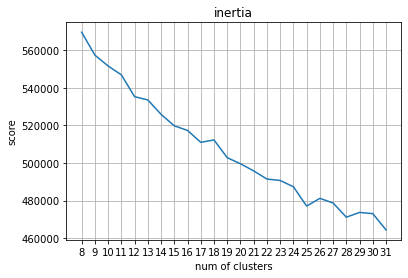

In [28]:
plt.figure()
plt.plot(k_values, inertia_scores)
plt.xlabel('num of clusters')
plt.ylabel('score')
plt.title('inertia')
plt.xticks(k_values)
plt.grid()
#plt.ylim(0,580000)
plt.show()

Based on the graph, there is a decrease in the slope at the following number of clusters: 15, 17, 25.

# View Cluster Features
For Kmeans, the optimal number of clusters are **15, 17, and 25.** As 25 has the lowest inertia, we'll be using 25 clusters.

### 25 clusters

In [29]:
#instantiate KMeans with 25 clusters
kmeans_model25 = KMeans(n_clusters=25, n_jobs=5, verbose=1)
#fitting KMeans on first 350 PCs
kmeans_model25.fit(PCA_components.iloc[:,0:350])

C:\Users\BRIDDHI\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Initialization complete
Iteration 0, inertia 751994.4578198928
Iteration 1, inertia 509700.38649736694
Iteration 2, inertia 494141.80540544586
Iteration 3, inertia 489364.93195196614
Iteration 4, inertia 486270.34352428437
Iteration 5, inertia 484900.07586335635
Iteration 6, inertia 482656.74923881015
Iteration 7, inertia 482235.9096310622
Iteration 8, inertia 482099.6179001715
Iteration 9, inertia 482060.9415361008
Iteration 10, inertia 482055.038617955
Iteration 11, inertia 482051.75571251655
Iteration 12, inertia 482049.3823561118
Iteration 13, inertia 482045.40804865496
Iteration 14, inertia 482043.49986730947
Iteration 15, inertia 482042.6168194504
Iteration 16, inertia 482042.0705822376
Iteration 17, inertia 482041.4276626498
Iteration 18, inertia 482040.84811021603
Iteration 19, inertia 482040.024471296
Iteration 20, inertia 482038.51842991845
Iteration 21, inertia 482031.90443875466
Iteration 22, inertia 482001.2810875762
Iteration 23, inertia 481981.8474935695
Iteration 24, in

Iteration 22, inertia 490087.6015957129
Iteration 23, inertia 490082.9147444546
Iteration 24, inertia 490082.65162964823
Iteration 25, inertia 490082.12811484426
Iteration 26, inertia 490073.689591915
Iteration 27, inertia 490057.37825991126
Iteration 28, inertia 489986.133690604
Iteration 29, inertia 489581.8088941458
Iteration 30, inertia 489363.328024996
Iteration 31, inertia 489363.2654692354
Converged at iteration 31: strict convergence.
Initialization complete
Iteration 0, inertia 752802.3220421403
Iteration 1, inertia 509110.01861031866
Iteration 2, inertia 496964.22627182177
Iteration 3, inertia 491375.7551893181
Iteration 4, inertia 488887.096453953
Iteration 5, inertia 486518.4199740801
Iteration 6, inertia 485225.44925842405
Iteration 7, inertia 485187.5370933866
Iteration 8, inertia 485179.2013066598
Iteration 9, inertia 485176.15348661185
Iteration 10, inertia 485174.5213121358
Iteration 11, inertia 485173.9096192869
Iteration 12, inertia 485173.02975984174
Iteration 13, i

KMeans(n_clusters=25, n_jobs=5, verbose=1)

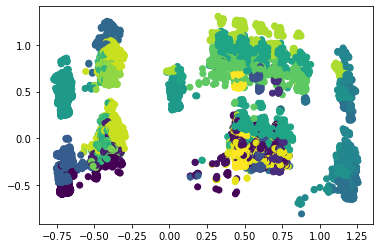

In [30]:
#let's take a look at the first 2 PCs with the labels generated from KMeans
plt.figure()
plt.scatter(PCA_components[0],PCA_components[1], c=kmeans_model25.labels_)
plt.show()

The are some vague clusters that can be seen from the first 2 PC but quite evidently they are not interpretable at this point.

Save the model in order to perform cluster analysis. We will also perform LDA topic modelling in parallel and compare the results of each model to try and find a cluster of fake reviews.

In [31]:
import joblib

In [32]:
#saving model to computer to be used for later analysis
joblib.dump(kmeans_model25, 'kmeans_model25.pkl')

['kmeans_model25.pkl']

##### Saving data
We can also save the dataframe with the cluster labels. We will need to perform matrix multiplication to convert the reviews from principal components back to the original features.

In [33]:
#getting 2 matrices
# 1) data with principal components (PCs)
# 2) PCs and features
# only getting 350 PCs as those the model was fit only on those PCs
data_pc_matrix = PCA_components.iloc[:,0:350].to_numpy()
pc_feature_matrix = pca.components_[0:350,:]

In [34]:
#performing matrix multiplication to get the reviews back in terms of the original features; will then save this reconstructed data to a dataframe
df_recon = pd.DataFrame(np.matmul(data_pc_matrix,pc_feature_matrix), columns=df_final.columns)

In [35]:
#adding cluster labels to the reconstructed dataframe
df_recon['cluster'] = kmeans_model25.labels_

In [36]:
#saving the df to the computer in a compressed h5 format (saves faster than other compression techniques)
df_recon.to_hdf('df_recon_25_kmeans.h5', key='df', mode='w')